In [ ]:
!pip install medmnist scikit-learn torchvision torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.9 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

import need library


In [2]:
import numpy as np
import torch
import torchvision.transforms as transforms
from medmnist import PneumoniaMNIST
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report


Prepare data

In [4]:
def compute_mean_std(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=500, shuffle=False)
    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, -1)
        mean += images.mean(dim=1).sum().item()
        std += images.std(dim=1).sum().item()
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples
    return mean, std

raw_dataset = PneumoniaMNIST(split='train', download=True, transform=transforms.ToTensor())
mean, std = compute_mean_std(raw_dataset)
print(f"Mean: {mean}, Std: {std}")


Mean: 0.5719215713928794, Std: 0.1447842394586529


load the data

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

train_dataset = PneumoniaMNIST(split='train', download=True, transform=transform)
test_dataset = PneumoniaMNIST(split='test', download=True, transform=transform)


Convert data to NumPy

In [6]:
X_train = np.array([img.numpy().flatten() for img, _ in train_dataset])
y_train = np.array([label for _, label in train_dataset]).flatten()

X_test = np.array([img.numpy().flatten() for img, _ in test_dataset])
y_test = np.array([label for _, label in test_dataset]).flatten()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Train: (3766, 784)
Validation: (942, 784)
Test: (624, 784)


train the model

In [7]:
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=10, random_state=42)

Evaluation on validation set

In [8]:
y_val_pred = dt_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


Validation Accuracy: 88.22%


Evaluation on Test Set

In [9]:
y_test_pred = dt_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 80.13%


Evaluation metrics f1-score

In [10]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_test_pred)
print(f"F1-score on Test Set: {f1:.4f}")

# print("Classification Report on Test Set:")
# print(classification_report(y_test, y_test_pred))

# f1 = f1_score(y_test, y_test_pred)
# print(f"F1-score on Test Set: {f1:.4f}")

f1_macro = f1_score(y_test, y_test_pred, average="macro")
print(f"Macro F1-score on Test Set: {f1_macro:.4f}")


F1-score on Test Set: 0.8565
Macro F1-score on Test Set: 0.7668


Evaluation metrics confusion table

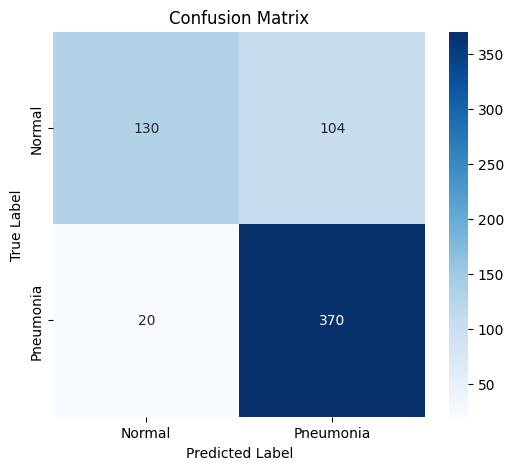

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
